Import Libraries

In [107]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import math
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor, VotingRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score


In [108]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load the dataset

In [109]:
# train_path = "./Datasets/train.csv"
train_path= "./Datasets/with-mrt-train.csv"
test_path = "./Datasets/with-mrt-test.csv"
output_path = "./Datasets/output.csv"

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

See train data distribution

In [110]:
train_data.shape

(60000, 20)

In [111]:
train_data.head()

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,latitude,longitude,elevation,subzone,planning_area,region,monthly_rent,MRT_1km,nearest_MRT_name,nearest_MRT_dis,mrt_average_price
0,2021-09,jurong east,257,Jurong East Street 24,3 room,new generation,67.0,yes,1983,1.344518,103.738630,0.0,yuhua east,jurong east,west region,1600,1.0,Chinese Garden,0.200699,2481.346424
1,2022-05,bedok,119,bedok north road,4-room,new generation,92.0,yes,1978,1.330186,103.938717,0.0,bedok north,bedok,east region,2250,1.0,Tanah Merah,0.000923,2425.980392
2,2022-10,toa payoh,157,lorong 1 toa payoh,3-room,improved,67.0,yes,1971,1.332242,103.845643,0.0,toa payoh central,toa payoh,central region,1900,4.0,Toa Payoh,0.518801,2632.947462
3,2021-08,pasir ris,250,Pasir Ris Street 21,executive,apartment,149.0,yes,1993,1.370239,103.962894,0.0,pasir ris drive,pasir ris,east region,2850,0.0,Pasir Ris,-0.647366,2687.550471
4,2022-11,kallang/whampoa,34,Whampoa West,3-room,improved,68.0,yes,1972,1.320502,103.863341,0.0,bendemeer,kallang,central region,2100,3.0,Boon Keng,0.487930,2589.985486


In [112]:
train_data.nunique()

rent_approval_date       31
town                     26
block                  2553
street_name            1083
flat_type                 9
flat_model               19
floor_area_sqm          146
furnished                 1
lease_commence_date      54
latitude               8612
longitude              8612
elevation                 1
subzone                 152
planning_area            29
region                    5
monthly_rent            113
MRT_1km                  15
nearest_MRT_name         96
nearest_MRT_dis        8630
mrt_average_price        96
dtype: int64

In [113]:
train_data.isna().sum()

rent_approval_date     0
town                   0
block                  0
street_name            0
flat_type              0
flat_model             0
floor_area_sqm         0
furnished              0
lease_commence_date    0
latitude               0
longitude              0
elevation              0
subzone                0
planning_area          0
region                 0
monthly_rent           0
MRT_1km                0
nearest_MRT_name       0
nearest_MRT_dis        0
mrt_average_price      0
dtype: int64

Data preprocessing of train_data

In [114]:
def data_preprocessing(data):
    data.replace("-", " ", regex=True, inplace=True)

    for col in data.columns:
        if data[col].dtype == 'object':
            data[col] = data[col].str.lower()
    
    data['lease_commence_date'] = 2021 - data['lease_commence_date']

    def convert_to_numeric(date_str):
        year, month = date_str.split(" ")
        return float(year) + float(month)/12.0
    data['rent_approval_date'] = [convert_to_numeric(date) for date in data['rent_approval_date']]

    data['MRT_1km']=np.sqrt(data['MRT_1km'])
    data['rent_approval_date'] = data['rent_approval_date'] - 2021
    
    # data = data.drop_duplicates()
    # data = data.reset_index(drop=True)
    # data['monthly_rent'] = np.log1p(data['monthly_rent'])
    # data.drop(data[(data['floor_area_sqm']<30)].index, inplace=True)
    # data.drop(data[(data['floor_area_sqm']>160)].index, inplace=True)
    # data.drop(data[(data['monthly_rent']>6000)].index, inplace=True)
    # data.drop(data[(data['monthly_rent']<500)].index, inplace=True)
    
    return data

train_data = data_preprocessing(train_data)
train_data


,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,latitude,longitude,elevation,subzone,planning_area,region,monthly_rent,MRT_1km,nearest_MRT_name,nearest_MRT_dis,mrt_average_price
0,0.750000,jurong east,257,jurong east street 24,3 room,new generation,67.0,yes,38,1.344518,103.738630,0.0,yuhua east,jurong east,west region,1600,1.000000,chinese garden,0.200699,2481.346424
1,1.416667,bedok,119,bedok north road,4 room,new generation,92.0,yes,43,1.330186,103.938717,0.0,bedok north,bedok,east region,2250,1.000000,tanah merah,0.000923,2425.980392
2,1.833333,toa payoh,157,lorong 1 toa payoh,3 room,improved,67.0,yes,50,1.332242,103.845643,0.0,toa payoh central,toa payoh,central region,1900,2.000000,toa payoh,0.518801,2632.947462
3,0.666667,pasir ris,250,pasir ris street 21,executive,apartment,149.0,yes,28,1.370239,103.962894,0.0,pasir ris drive,pasir ris,east region,2850,0.000000,pasir ris,-0.647366,2687.550471
4,1.916667,kallang/whampoa,34,whampoa west,3 room,improved,68.0,yes,49,1.320502,103.863341,0.0,bendemeer,kallang,central region,2100,1.732051,boon keng,0.487930,2589.985486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0.750000,ang mo kio,441,ang mo kio avenue 10,3 room,new generation,67.0,yes,42,1.366050,103.854168,0.0,chong boon,ang mo kio,north east region,2200,1.000000,ang mo kio,0.231013,2461.518550
59996,2.333333,bukit merah,95a,henderson road,4 room,model a,83.0,yes,2,1.286493,103.821434,0.0,henderson hill,bukit merah,central region,4100,1.414214,tiong bahru,0.279747,2881.436907
59997,1.500000,tampines,862a,tampines street 83,5 room,improved,122.0,yes,33,1.355064,103.936507,0.0,tampines west,tampines,east region,2250,1.414214,tampines,0.176264,2643.672840
59998,2.083333,bedok,67,bedok sth avenue 3,5 room,standard,123.0,yes,44,1.318974,103.944076,0.0,bedok south,bedok,east region,4700,1.000000,tanah merah,-0.018778,2425.980392


Feature Engineering of train_data

In [115]:
X_train_num = train_data.select_dtypes(include = ['float64', 'int64'])
print(X_train_num.shape)
X_train_num.head()

(60000, 10)


,rent_approval_date,floor_area_sqm,lease_commence_date,latitude,longitude,elevation,monthly_rent,MRT_1km,nearest_MRT_dis,mrt_average_price
0,0.750000,67.0,38,1.344518,103.738630,0.0,1600,1.000000,0.200699,2481.346424
1,1.416667,92.0,43,1.330186,103.938717,0.0,2250,1.000000,0.000923,2425.980392
2,1.833333,67.0,50,1.332242,103.845643,0.0,1900,2.000000,0.518801,2632.947462
3,0.666667,149.0,28,1.370239,103.962894,0.0,2850,0.000000,-0.647366,2687.550471
4,1.916667,68.0,49,1.320502,103.863341,0.0,2100,1.732051,0.487930,2589.985486


In [116]:
X_train_cat = train_data.select_dtypes(include = ['object'])
print(X_train_cat.shape)
X_train_cat.head()

(60000, 10)


,town,block,street_name,flat_type,flat_model,furnished,subzone,planning_area,region,nearest_MRT_name
0,jurong east,257,jurong east street 24,3 room,new generation,yes,yuhua east,jurong east,west region,chinese garden
1,bedok,119,bedok north road,4 room,new generation,yes,bedok north,bedok,east region,tanah merah
2,toa payoh,157,lorong 1 toa payoh,3 room,improved,yes,toa payoh central,toa payoh,central region,toa payoh
3,pasir ris,250,pasir ris street 21,executive,apartment,yes,pasir ris drive,pasir ris,east region,pasir ris
4,kallang/whampoa,34,whampoa west,3 room,improved,yes,bendemeer,kallang,central region,boon keng


In [117]:
print(X_train_cat.groupby('flat_model').size())


flat_model
2 room                       34
3gen                          3
adjoined flat                49
apartment                  2080
dbss                        371
improved                  17010
maisonette                  956
model a                   17122
model a maisonette           56
model a2                    663
new generation            11292
premium apartment          5109
premium apartment loft       25
premium maisonette            6
simplified                 2798
standard                   2268
terrace                       4
type s1                     108
type s2                      46
dtype: int64


array([[<AxesSubplot:title={'center':'rent_approval_date'}>,
        <AxesSubplot:title={'center':'floor_area_sqm'}>,
        <AxesSubplot:title={'center':'lease_commence_date'}>],
       [<AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'elevation'}>],
       [<AxesSubplot:title={'center':'monthly_rent'}>,
        <AxesSubplot:title={'center':'MRT_1km'}>,
        <AxesSubplot:title={'center':'nearest_MRT_dis'}>],
       [<AxesSubplot:title={'center':'mrt_average_price'}>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

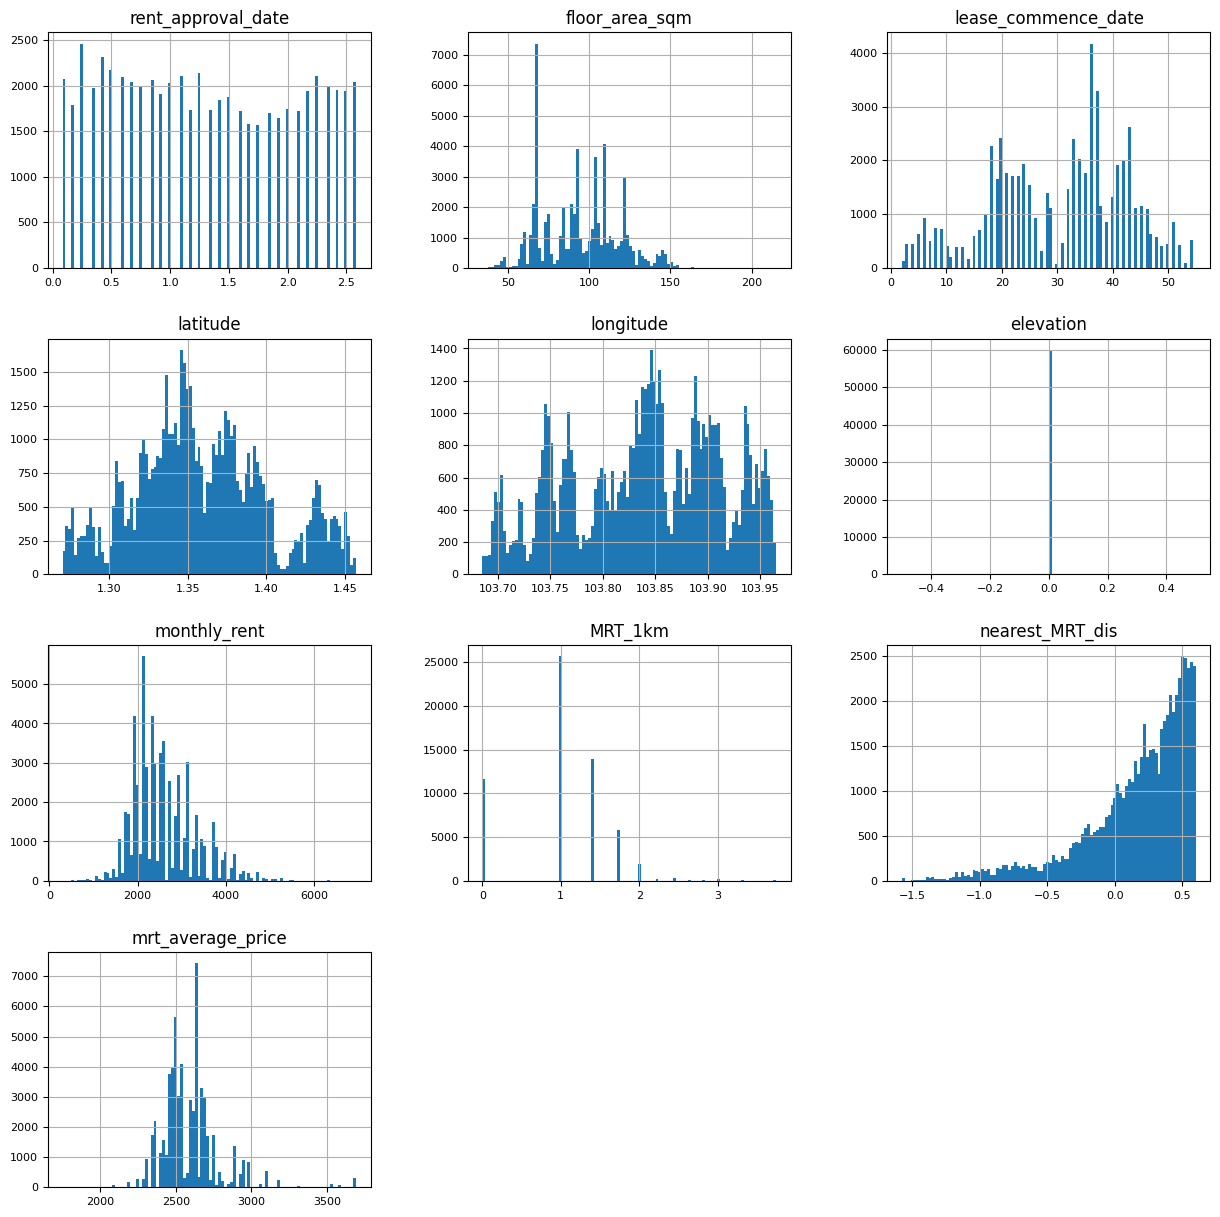

In [118]:
X_train_num.hist(figsize=(15, 15), bins=100, xlabelsize=8, ylabelsize=8)

<AxesSubplot:>

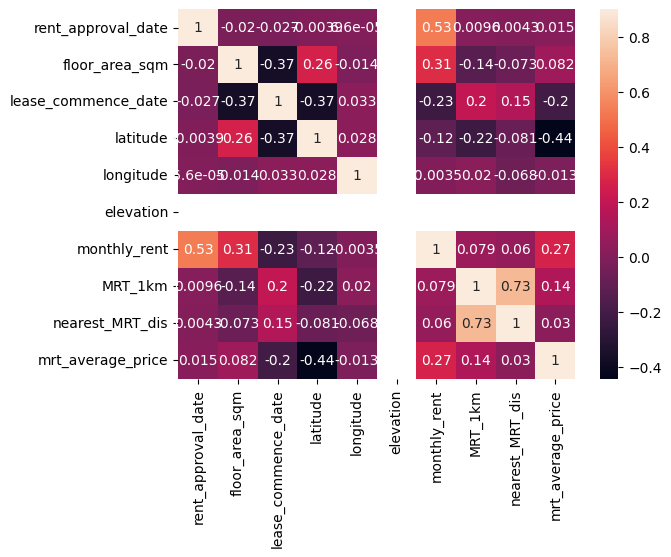

In [119]:
corrmat = X_train_num.corr()
sns.heatmap(corrmat, vmax=.9, annot=True)

count    60000.000000
mean      2590.328333
std        714.910468
min        300.000000
25%       2100.000000
50%       2400.000000
75%       3000.000000
max       6950.000000
Name: monthly_rent, dtype: float64


<Figure size 640x480 with 0 Axes>

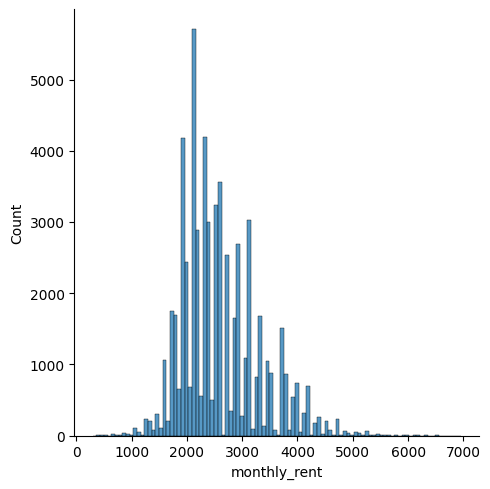

In [120]:
y_train = train_data['monthly_rent']
print(y_train.describe())
plt.figure()
sns.displot(y_train, bins=100)

In [121]:
def feature_engineering(data):
    # numerical feature
    data_num = data.select_dtypes(include = ['float64', 'int64'])
    data_num = data_num[['rent_approval_date', 'floor_area_sqm', 'lease_commence_date','MRT_1km','nearest_MRT_dis','mrt_average_price']]

    # categorical feature
    data_cat = data.select_dtypes(include = ['object'])
    data_cat_one_hot = pd.get_dummies(data[['flat_type', 'region']]) # , 'planning_area', 'town', 'flat_model'

    data_cat_target = pd.DataFrame()
    
    town_encoded = train_data.groupby('town')['monthly_rent'].mean()
    data_cat_target['town_encoded'] = data['town'].map(town_encoded)
    
    planning_area_encoded = train_data.groupby('planning_area')['monthly_rent'].mean()
    data_cat_target['planning_area_encoded'] = data['planning_area'].map(planning_area_encoded)

    subzone_encoded = train_data.groupby('subzone')['monthly_rent'].mean()
    data_cat_target['subzone_encoded'] = data['subzone'].map(subzone_encoded)

    flat_model_encoded = train_data.groupby('flat_model')['monthly_rent'].mean()
    data_cat_target['flat_model_encoded'] = data['flat_model'].map(flat_model_encoded)

    # block_encoded = train_data.groupby('block')['monthly_rent'].mean()
    # data_cat_target['block_encoded'] = data['block'].map(block_encoded)

    # street_name_encoded = train_data.groupby('street_name')['monthly_rent'].mean()
    # data_cat_target['street_name_encoded'] = data['street_name'].map(street_name_encoded)

    # data_cat_target['town_encoded'] = train_data.groupby('town')['monthly_rent'].transform('mean')
    # data_cat_target['planning_area_encoded'] = train_data.groupby('planning_area')['monthly_rent'].transform('mean')
    # data_cat_target['block_encoded'] = train_data.groupby('block')['monthly_rent'].transform('mean')
    # data_cat_target['street_name_encoded'] = train_data.groupby('street_name')['monthly_rent'].transform('mean')

    # Concate all the choosed features
    data_filter = pd.concat([data_num, data_cat_one_hot, data_cat_target], axis=1)

    return data_filter

X_train = feature_engineering(train_data)
X_train
    

,rent_approval_date,floor_area_sqm,lease_commence_date,MRT_1km,nearest_MRT_dis,mrt_average_price,flat_type_2 room,flat_type_3 room,flat_type_4 room,flat_type_5 room,flat_type_executive,region_central region,region_east region,region_north east region,region_north region,region_west region,town_encoded,planning_area_encoded,subzone_encoded,flat_model_encoded
0,0.750000,67.0,38,1.000000,0.200699,2481.346424,0,1,0,0,0,0,0,0,0,1,2595.146199,2595.146199,2542.158516,2369.965462
1,1.416667,92.0,43,1.000000,0.000923,2425.980392,0,0,1,0,0,0,1,0,0,0,2438.227223,2438.227223,2360.371046,2369.965462
2,1.833333,67.0,50,2.000000,0.518801,2632.947462,0,1,0,0,0,1,0,0,0,0,2516.680515,2516.680515,2808.893871,2636.211052
3,0.666667,149.0,28,0.000000,-0.647366,2687.550471,0,0,0,0,1,0,1,0,0,0,2686.857477,2686.857477,2610.338573,2878.725962
4,1.916667,68.0,49,1.732051,0.487930,2589.985486,0,1,0,0,0,1,0,0,0,0,2665.537634,2702.635659,2793.525180,2636.211052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0.750000,67.0,42,1.000000,0.231013,2461.518550,0,1,0,0,0,0,0,1,0,0,2416.700057,2416.700057,2390.887097,2369.965462
59996,2.333333,83.0,2,1.414214,0.279747,2881.436907,0,0,1,0,0,1,0,0,0,0,2904.113924,2904.113924,2694.936709,2612.031305
59997,1.500000,122.0,33,1.414214,0.176264,2643.672840,0,0,0,1,0,0,1,0,0,0,2638.489123,2638.489123,2602.823315,2636.211052
59998,2.083333,123.0,44,1.000000,-0.018778,2425.980392,0,0,0,1,0,0,1,0,0,0,2438.227223,2438.227223,2434.379786,2444.223986


## Start to train

### Training preparation

#### Train-Test Split

In [122]:
X, y = X_train, y_train
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

#### Define evaluation metrics

In [123]:
# def rmse_cv(model):
#     rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5)).mean()
#     return rmse

def evaluation(y, predictions):
    mae = mean_absolute_error(y, predictions)
    r_squared = r2_score(y, predictions)
    mse = mean_squared_error(y, predictions)
    rmse = np.sqrt(mean_squared_error(y, predictions))
    
    print("MAE:", mae)
    print("R2 Score:", r_squared)
    print("MSE:", mse)
    print("RMSE:", rmse)
    

### Linear Models

#### Linear Regression(Ordinary Least Squares)

In [78]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
predictions = lin_reg.predict(X_test)

evaluation(y_test, predictions)

MAE: 396.2936241479892
R2 Score: 0.48057435925186076
MSE: 262037.7517859978
RMSE: 511.8962314629771


#### Ridge Regression

In [79]:
ridge = Ridge()
ridge.fit(X_train, y_train)
predictions = ridge.predict(X_test)

evaluation(y_test, predictions)

MAE: 396.2748373060846
R2 Score: 0.48063681345668297
MSE: 262006.2451407008
RMSE: 511.86545609241966


#### Lasso Regression

In [80]:
lasso = Lasso()
lasso.fit(X_train, y_train)
predictions = lasso.predict(X_test)

evaluation(y_test, predictions)

MAE: 396.88285318688565
R2 Score: 0.47898676079251856
MSE: 262838.6570521024
RMSE: 512.6779272136673


#### Elastic-Net Regression

In [81]:
elastic_net = ElasticNet()
elastic_net.fit(X_train, y_train)
predictions = elastic_net.predict(X_test)

evaluation(y_test, predictions)

MAE: 432.1655849890482
R2 Score: 0.3922761654051031
MSE: 306582.0684066468
RMSE: 553.6985356732008


#### Stochastic Gradient Descent - SGD

In [82]:
scaler = StandardScaler()
X_train_sgd = scaler.fit_transform(X_train)
X_test_sgd = scaler.transform(X_test)

sgd = SGDRegressor(loss="epsilon_insensitive")
sgd.fit(X_train_sgd, y_train)
predictions = sgd.predict(X_test_sgd)

evaluation(y_test, predictions)

MAE: 396.29090963215003
R2 Score: 0.47351354577454563
MSE: 265599.76248441276
RMSE: 515.3637186341437


#### Polynomial regression

In [83]:
poly_reg = PolynomialFeatures(degree=2)
X_train_2d = poly_reg.fit_transform(X_train)
X_test_2d = poly_reg.transform(X_test)

lin_reg = LinearRegression()
lin_reg.fit(X_train_2d, y_train)
predictions = lin_reg.predict(X_test_2d)

evaluation(y_test, predictions)

MAE: 379.2831026859181
R2 Score: -0.29055157467985393
MSE: 651052.2520719431
RMSE: 806.8780899689514


### Support Vector Machines

#### Support Vector Regression

In [84]:
svr = SVR(C=200000)
svr.fit(X_train, y_train)
predictions = svr.predict(X_test)

evaluation(y_test, predictions)

MAE: 433.1164673415527
R2 Score: 0.3578212390374744
MSE: 323963.7506630745
RMSE: 569.1781361428726


### Nearest Neighbors

#### Nearest Neighbors Regression

In [85]:
scaler = StandardScaler()
X_train_nn = scaler.fit_transform(X_train)
X_test_nn = scaler.transform(X_test)

knn_reg = KNeighborsRegressor(n_neighbors=20)
knn_reg.fit(X_train_nn, y_train)
predictions = knn_reg.predict(X_test_nn)

evaluation(y_test, predictions)

MAE: 377.5025
R2 Score: 0.5052666483070646
MSE: 249581.08541666667
RMSE: 499.58090978005424


### Decision Tree

#### DecisionTreeRegressor

In [88]:
tree_reg = DecisionTreeRegressor(max_depth=10,min_samples_leaf=50)
tree_reg.fit(X_train, y_train)
predictions = tree_reg.predict(X_test)

evaluation(y_test, predictions)

MAE: 378.35414399202153
R2 Score: 0.5036180937087895
MSE: 250412.74158983186
RMSE: 500.4125713746926


### Ensemble Methods

#### Gradient-boosted trees

In [124]:
hist_reg = HistGradientBoostingRegressor(max_iter=1000, learning_rate=0.01)
hist_reg.fit(X_train, y_train)
predictions = hist_reg.predict(X_test)

evaluation(y_test, predictions)

MAE: 365.77071257770586
R2 Score: 0.5372325084541628
MSE: 233455.077245821
RMSE: 483.17189202790036


#### Random Forest

In [89]:
random_forest = RandomForestRegressor(n_estimators=1200,max_depth=15,min_samples_split=5,min_samples_leaf=5,max_features=None,oob_score=True)
random_forest.fit(X_train, y_train)
predictions = random_forest.predict(X_test)

evaluation(y_test, predictions)

MAE: 369.4094416703107
R2 Score: 0.5231673973982035
MSE: 240550.58773008498
RMSE: 490.45956788514684


#### BaggingRegressor

In [52]:
bag_reg = BaggingRegressor(n_estimators=100)
bag_reg.fit(X_train, y_train)
predictions = bag_reg.predict(X_test)

evaluation(y_test, predictions)

MAE: 404.013242792797
R2 Score: 0.421280250718412
MSE: 291950.2044556064
RMSE: 540.3241660851442


#### AdaBoost Regressor

In [53]:
base_reg = LinearRegression()
ada_reg = AdaBoostRegressor(base_estimator=base_reg, n_estimators=1000)
ada_reg.fit(X_train, y_train)
predictions = ada_reg.predict(X_test)

evaluation(y_test, predictions)

MAE: 391.7104991024138
R2 Score: 0.48988622484358446
MSE: 257340.1393980644
RMSE: 507.2870384684241


#### XGBoost Regressor

In [125]:
xgb = XGBRegressor(n_estimators=1000, learning_rate=0.01)
xgb.fit(X_train, y_train)
predictions = xgb.predict(X_test)

evaluation(y_test, predictions)

MAE: 364.9062594095866
R2 Score: 0.5372093154692297
MSE: 233466.77754929528
RMSE: 483.1839996826212


#### Voting Regressor(Blend different regressors)

In [126]:
voting_reg = VotingRegressor(estimators=[('hist', hist_reg), ('xgb', xgb)])
voting_reg.fit(X_train, y_train)
predictions = voting_reg.predict(X_test)

evaluation(y_test, predictions)


MAE: 364.8103421832635
R2 Score: 0.5381992884591531
MSE: 232967.35996907196
RMSE: 482.66692446144674


### Neural network models (supervised)

#### MLP Regressor

In [93]:
mlp_reg = MLPRegressor(learning_rate='adaptive')
mlp_reg.fit(X_train, y_train)
predictions = mlp_reg.predict(X_test)

evaluation(y_test, predictions)

MAE: 388.82470923170416
R2 Score: 0.493621647642552
MSE: 255455.70837382428
RMSE: 505.42626403247414


### Blend methods

In [127]:
def blended_pred(x):
    return 0.5 * xgb.predict(x) + 0.5 * hist_reg.predict(x)# + 0.05 * ada_reg.predict(x)


evaluation(y_test, blended_pred(X_test))

MAE: 364.9477152984361
R2 Score: 0.5382240373078777
MSE: 232954.87476970878
RMSE: 482.6539907321898


## Predict on test data

Predicet test dataset

In [128]:
test_data = data_preprocessing(test_data)
test_data = feature_engineering(test_data)

test_data

,rent_approval_date,floor_area_sqm,lease_commence_date,MRT_1km,nearest_MRT_dis,mrt_average_price,flat_type_2 room,flat_type_3 room,flat_type_4 room,flat_type_5 room,flat_type_executive,region_central region,region_east region,region_north east region,region_north region,region_west region,town_encoded,planning_area_encoded,subzone_encoded,flat_model_encoded
0,2.083333,121.0,37,1.000000,0.078970,2529.932302,0,0,0,1,0,0,0,1,0,0,2503.252886,2503.252886,2427.604167,2636.211052
1,1.750000,100.0,22,1.000000,0.593808,2531.304665,0,0,1,0,0,0,0,0,1,0,2540.491010,2540.491010,2592.332790,2612.031305
2,2.583333,91.0,41,0.000000,-0.192259,2636.174071,0,0,1,0,0,0,0,0,0,1,2646.808979,2646.808979,2395.588235,2369.965462
3,0.666667,74.0,35,1.000000,0.538309,2481.346424,0,1,0,0,0,0,0,0,0,1,2595.146199,2595.146199,2400.150150,2612.031305
4,1.250000,121.0,38,1.000000,0.452393,2481.346424,0,0,0,1,0,0,0,0,0,1,2595.146199,2595.146199,2400.150150,2636.211052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,1.666667,92.0,9,1.000000,0.024699,2666.429094,0,0,1,0,0,0,0,1,0,0,2665.555556,2665.555556,2654.294479,2612.031305
29996,2.166667,90.0,17,1.000000,0.071360,2531.304665,0,0,1,0,0,0,0,0,1,0,2540.491010,2540.491010,2473.678647,2612.031305
29997,2.416667,68.0,41,1.000000,0.356386,2461.518550,0,1,0,0,0,0,0,1,0,0,2416.700057,2416.700057,2378.606965,2369.965462
29998,2.166667,144.0,23,1.000000,0.457365,2502.786033,0,0,0,0,1,0,0,0,1,0,2466.298251,2466.298251,2497.040971,2978.033473


In [129]:
test_data = test_data.reindex(columns=X_train.columns, fill_value=False)

test_data

,rent_approval_date,floor_area_sqm,lease_commence_date,MRT_1km,nearest_MRT_dis,mrt_average_price,flat_type_2 room,flat_type_3 room,flat_type_4 room,flat_type_5 room,flat_type_executive,region_central region,region_east region,region_north east region,region_north region,region_west region,town_encoded,planning_area_encoded,subzone_encoded,flat_model_encoded
0,2.083333,121.0,37,1.000000,0.078970,2529.932302,0,0,0,1,0,0,0,1,0,0,2503.252886,2503.252886,2427.604167,2636.211052
1,1.750000,100.0,22,1.000000,0.593808,2531.304665,0,0,1,0,0,0,0,0,1,0,2540.491010,2540.491010,2592.332790,2612.031305
2,2.583333,91.0,41,0.000000,-0.192259,2636.174071,0,0,1,0,0,0,0,0,0,1,2646.808979,2646.808979,2395.588235,2369.965462
3,0.666667,74.0,35,1.000000,0.538309,2481.346424,0,1,0,0,0,0,0,0,0,1,2595.146199,2595.146199,2400.150150,2612.031305
4,1.250000,121.0,38,1.000000,0.452393,2481.346424,0,0,0,1,0,0,0,0,0,1,2595.146199,2595.146199,2400.150150,2636.211052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,1.666667,92.0,9,1.000000,0.024699,2666.429094,0,0,1,0,0,0,0,1,0,0,2665.555556,2665.555556,2654.294479,2612.031305
29996,2.166667,90.0,17,1.000000,0.071360,2531.304665,0,0,1,0,0,0,0,0,1,0,2540.491010,2540.491010,2473.678647,2612.031305
29997,2.416667,68.0,41,1.000000,0.356386,2461.518550,0,1,0,0,0,0,0,1,0,0,2416.700057,2416.700057,2378.606965,2369.965462
29998,2.166667,144.0,23,1.000000,0.457365,2502.786033,0,0,0,0,1,0,0,0,1,0,2466.298251,2466.298251,2497.040971,2978.033473


In [130]:
# best_model = hist_reg
# test_pred = best_model.predict(test_data)

test_pred = blended_pred(test_data)
test_pred

array([3228.91480055, 2744.25615891, 3367.46791775, ..., 2658.13166049,
       3330.93963736, 3444.66083412])

In [131]:
print(test_pred.shape)

(30000,)


In [132]:
sample_submission_path = './Datasets/example-submission.csv'
sample_submission_df = pd.read_csv(sample_submission_path)
sample_submission_df['Predicted'] = test_pred
sample_submission_df.to_csv('./Datasets/submission.csv', index=False)
sample_submission_df.head()

,Id,Predicted
0,0,3228.914801
1,1,2744.256159
2,2,3367.467918
3,3,1983.234207
4,4,2648.537685
